# Application of Neural Networks

We use Pytorch module to train a neural network on the training set for prediction.


### 1. Data Loading

We first load the training set and the test set (.NPY files).


In [1]:
import numpy as np
xs_test = np.load('data/xs_test.npy')
xs_train = np.load('data/xs_train.npy')
ys_test = np.load('data/ys_test.npy')
ys_train = np.load('data/ys_train.npy')

We will not do K-fold cross validation in this part. Instead, we split 25% data from the training set to form a fixed validation set, so that the overall ratio of training set, validation set and test set is 6:2:2.

In [2]:
from sklearn.model_selection import train_test_split

# randomize the data and perform the training-validation split (75% for training and 25% for validation)
xs_train, xs_valid, ys_train, ys_valid = train_test_split(
    xs_train, ys_train, test_size=0.25, random_state=66, shuffle=True, stratify=ys_train)

# show the shape of training set, validation set and test set
print('training set shape:\t', xs_train.shape)
print('validation set shape:', xs_valid.shape)
print('test set shape:\t', xs_test.shape)


training set shape:	 (1036, 6)
validation set shape: (346, 6)
test set shape:	 (346, 6)


What's more, the dictionary files (.CSV) are also loaded.


In [3]:
import csv

att_dic = {}
class_dic = {}

# read the .csv files back to the dictionaries
with open('data/att_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        att_dic[row[0]] = row[1]

with open('data/class_dic.csv', 'r') as w:
    csvreader = csv.reader(w)
    for row in csvreader:
        class_dic[row[0]] = row[1]


Then we convert the type of the datasets from numpy.ndarray to tensor so that it can be used in Pytorch.


In [4]:
import torch
# convert the type of the training set and the test set from numpy.ndarray to tensor
tensor_xs_valid = torch.from_numpy(xs_valid).type(torch.FloatTensor)
tensor_ys_valid = torch.from_numpy(ys_valid).type(torch.LongTensor)
tensor_xs_train = torch.from_numpy(xs_train).type(torch.FloatTensor)
tensor_ys_train = torch.from_numpy(ys_train).type(torch.LongTensor)

Then, the Dataloader class in PyTorch is used to automatically batch the dataset, which can boost up the training process and save memory.


In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

#  combine the xs and the ys into one dataset
train_set = TensorDataset(tensor_xs_train, tensor_ys_train)
valid_set = TensorDataset(tensor_xs_valid, tensor_ys_valid)

# use DataLoader to generate an iterator for the training set to return examples in batch
train_loader = DataLoader(
    dataset=train_set, batch_size=10, shuffle=True, num_workers=2
)
# use DataLoader to generate an iterator for the validation set to return examples in batch (20 by 20)
valid_loader = DataLoader(
    dataset=valid_set, batch_size=20, shuffle=True, num_workers=2
)

### 2. Define the Multi-Layer Perceptron Network

We then create a class called MLPerceptron() to define the components of the neural network. It has 4 attributes (input_size, hidden_layer_sizes, output_size and activation_function) so that we can adjust the structure of the network easily when doing hyper-parameter tuning. 

In the forward method which is used to combine all the parts of the network together, different activation functions are used to transform the summed weighted input into an output value according to the users' choices (through the parameter called activation_function).

In [7]:
import torch.nn as nn

# a class to define the components of the neural network.
class MLPerceptron(nn.Module):

    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_function):
        super(MLPerceptron, self).__init__()
        # a list of layers
        self.layers = nn.ModuleList()
        # get the size of input layer
        next_hidden_size = input_size
        # define the input and the hidden layers
        for hidden_size in hidden_layer_sizes:
            self.layers.append(nn.Linear(next_hidden_size, hidden_size))
            next_hidden_size = hidden_size
        # define the output layer
        self.output = nn.Linear(next_hidden_size, output_size)
        self.activation_function = activation_function

    # a method to define the forward pass
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
            # the activation function which may work after each layer (except output layer)
            # here the activation function is chosen according to self.activation_function
            if self.activation_function == 'Sigmoid':
                out = torch.sigmoid(out)
            elif self.activation_function == 'ReLU':
                out = torch.relu(out)
            elif self.activation_function == 'Tanh':
                out = torch.tanh(out)
        out = self.output(out)
        return out

### 3. Define the Training Process of the Neural Network

Then, we define the training process of the neural network with the functions below. Model, epochs, optimizer and loss function are all set as parameters of these functions so that they can be changed in the part of hyper-parameter tuning.

To calculate the loss of the model on the validation set after each epoch, a function called compute_loss_validation() is defined.

In [8]:
# a function used to calculate the loss on the validation set
def compute_loss_validation(model, loss_func):
    # a variable to record whether the code is ruuning on CPU or GPU
    global device
    total_loss = 0
    batch_size = valid_loader.batch_size
    # for each batch
    for i, batch in enumerate(valid_loader):
        xs, ys = batch
        ys = ys.squeeze()
        xs=xs.to(device)
        ys=ys.to(device)
        # predict ys with the batch of xs using the current model
        pred_ys = model(xs)
        # calculate the loss of the prediction
        loss = loss_func(pred_ys, ys)
        # get the value and add it to the total loss
        total_loss += loss.item()
        if (i+1) % batch_size == 0:
            break

    # normalize the loss based on the number of validation examples
    loss = total_loss / len(valid_loader)
    return loss

Similarly, in order to calculate the weighted F1 score of the model on the training set and on the validation set after each epoch, we also define a function called F1_score().

In [9]:
from sklearn.metrics import f1_score

# a function used to calculate the F1 score of the model on a certain dataset
def F1_score(model, xs, ys):
    # a variable to record whether the code is ruuning on CPU or GPU
    global device
    # convert the numpy.ndarray to tensor
    xs = torch.from_numpy(xs).type(torch.FloatTensor).to(device)
    hat_ys = model(xs)
    _, hat_ys = torch.max(hat_ys, 1)
    ys_pred = hat_ys.cpu().numpy().tolist()
    return f1_score(ys, ys_pred, average='weighted')

Then, with the two functions above, we define the function used to train the model. The loss and F1 scores on the training set and validation set after each epoch are stored in 4 lists (training_loss_list, validation_loss_list, training_F1_list, validation_F1_list). To avoid overfitting, the function also records the best F1 score on the validation set and the best model (which gets the best F1 score).

In [10]:
import copy

# a function used to train the model with the given hyper parameters
def train_model(model, epochs, optimizer, loss_func):
    # a variable to record whether the code is ruuning on CPU or GPU
    global device
    model.to(device)
    # set the model to training mode
    model.train()
    running_loss = 0
    # two list to store the training loss and validation loss of each epoch
    training_loss_list = []
    validation_loss_list = []
    # two list to store the F1 score on the training set and validation set
    training_F1_list = []
    validation_F1_list = []
    # a variable used to store the best F1 score
    best_validation_F1 = 0
    # for each epoch
    for epoch in range(epochs):
        # for each batch
        for i, batch in enumerate(train_loader):
            xs, ys = batch
            ys = ys.squeeze()
            xs=xs.to(device)
            ys=ys.to(device)
            # reset the gradients
            optimizer.zero_grad()
            # predict ys with the batch of xs using the current model
            pred_ys = model(xs)
            # calculate the loss of the prediction
            loss = loss_func(pred_ys, ys)
            # backpropagation
            loss.backward()
            # optmize the model for one step
            optimizer.step()
            running_loss += loss.item()

        # after each epoch, print statistics about the training
        # training loss on the last batch
        running_loss /= len(train_loader)
        # keep track of the training loss
        training_loss_list.append(running_loss)
        # set the model to eval, we can now test the model
        model.eval()
        # compute the validation loss
        validation_loss = compute_loss_validation(model, loss_func)
        # keep track of the validation loss
        validation_loss_list.append(validation_loss)

        # set back the model to train
        model.train()
        print('Epoch [%d/%d], Train Loss: %.4f, Validation Loss: %.4f' %
              (epoch+1, epochs, running_loss, validation_loss))
        running_loss = 0

        # print and store the F1 score on the training set and on the validation set for each epoch
        validation_F1_score = F1_score(model, xs_valid, ys_valid)
        training_F1_score = F1_score(model, xs_train, ys_train)
        print('F1 Score (training set):', round(training_F1_score, 4),
              'F1 Score (validation set):', round(validation_F1_score, 4))
        training_F1_list.append(training_F1_score)
        validation_F1_list.append(validation_F1_score)

        # update the best F1 score and best_model 
        if validation_F1_score > best_validation_F1:
            best_validation_F1 = validation_F1_score
            best_model = copy.deepcopy(model)
    return best_validation_F1, training_loss_list, validation_loss_list, training_F1_list, validation_F1_list, best_model


### 4. Parameter Tuning

After defining the training process of the network, to tune the hyper-parameters (such as activation function, learning rate and loss function), we try to do grid search on the model.

Since training a neural network demands massive computing resources, to speed up the process of grid search, we try to use GPU to train the models with different hyper-parameters. 

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Since there are infinite combinations of the number of hidden layers and the number of nodes in each layer, to simplify the design of the network, following the rule of thumb put forward by MJA Berry, we assume the number of hidden layers and the number of nodes in each layer should obey the following relationship:  

$N_i=InputSize*2-(i-1)* \lceil (InputSize*2-OutputSize)/L \rceil (i\in (1,2,…,L))$ 

In which $L$ is the number of hidden layers and $N_i$ represents the number of nodes in the $i$ th layer.

To realise the relationship, we define a function called net_size().

In [12]:
import math

# a function to form a list which stores the number of nodes in each layer according to the number of layers, input size and output size
def net_size(num_of_layers, input_size, output_size):
    if num_of_layers <= (input_size*2-output_size+1):
        layers = []
        step = math.ceil((input_size*2-output_size)/num_of_layers)
        for i in range(num_of_layers):
            layers.append(input_size*2-i*step)
        return layers
    else:
        return 'the number of layers should not be larger than (input_size*2-output_size+1)'


By setting the parameters of this function, we can easily get the network structure which follows the relationship above.

For example, assuming the input_size is 6 and the output_size is 4, then the output of the function in different num_of_layers settings are:

In [13]:
for i in range(1,6):
    print(i,"layer(s):", net_size(i,6,4))

1 layer(s): [12]
2 layer(s): [12, 8]
3 layer(s): [12, 9, 6]
4 layer(s): [12, 10, 8, 6]
5 layer(s): [12, 10, 8, 6, 4]


Since there is no existing grid search method in Pytorch, we write one by ourselves with which we can train a network with each combination of the hyper-parameters and see which one can do the best prediction on the validation set.

In [13]:
import itertools

# a function used to find the best combination of the hyper-parameters


def grid_search(param_grid):
    global device
    # transform dictionary to lists
    value_list = list(param_grid.values())
    # list all the possible combination of hyper parameters
    combinations = list(itertools.product(*value_list))
    best_F1_score = 0
    best_combinations = 0
    # for each combination
    for i, combination in enumerate(combinations):
        print(combination)
        model = MLPerceptron(6, net_size(
            combination[0], 6, 4), 4, combination[1])
        # define the loss
        if combination[2] == 'CrossEntropyLoss':
            loss_func = nn.CrossEntropyLoss().to(device)
        # define the optimizer
        if combination[3] == 'SGD':
            optimizer = torch.optim.SGD(
                model.parameters(), lr=combination[4])
            device = torch.device(
                "cuda:0" if torch.cuda.is_available() else "cpu")
        elif combination[3] == 'Adam':
            optimizer = torch.optim.Adam(
                model.parameters(), lr=combination[4])
            device = torch.device(
                "cuda:0" if torch.cuda.is_available() else "cpu")
        elif combination[3] == 'Adagrad':
            optimizer = torch.optim.Adagrad(
                model.parameters(), lr=combination[4])
            # Adagrad doesn't support CUDA computing, thus the device should be switched to CPU
            device = 'cpu'
        # define the number of epochs
        epochs = combination[5]
        F1_score, training_loss_list, validation_loss_list, training_F1_list, validation_F1_list, best_model = train_model(
            model, epochs, optimizer, loss_func)
        # update the best F1 score and best combinations
        if F1_score > best_F1_score:
            best_F1_score = F1_score
            best_combinations = i
    return combinations[best_combinations]


Then, we define a dictionary called param_grid which contains the possible values of each hyper-parameter and use the grid_search() function to try each combination of the parameters and output the one which has the best prediction performance on the validation set.

<b>To ensure that the models fit well, here we set the number of epochs as 150.</b>

### Caution: Please do not run this code!!!!! For it takes more than 5 hours to run.

In [ ]:
# a dictionary containing the possible values of hyper-parameters
param_grid = {
    'num_of_hidden_layers': range(1,5),
    'activation_function': ['Sigmoid', 'ReLU', 'Tanh'],
    'loss_func': ['CrossEntropyLoss'],
    'optimizer': ['SGD', 'Adam', 'Adagrad'],
    'lr': [0.01, 0.001, 0.0001],
    'epochs': [150]
}

best_params=grid_search(param_grid)

We can now see the best combination of the hyperparameters.

In [29]:
# print the best combination of the hyper-parameters
print('Best hyper-parameters:')
print('Structure of the hidden layers:',net_size(best_params[0],6,4))
print('Activation function:',best_params[1])
print('Loss function:',best_params[2])
print('Optimizer:', best_params[3])
print('Learning rate:',best_params[4])

Best hyper-parameters:
Structure of the hidden layers: [12, 8]
Activation function: Sigmoid
Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.01


Now we can visualise the best network with hiddenlayer package.

In [34]:
# commands to install the package
# !pip install hiddenlayer

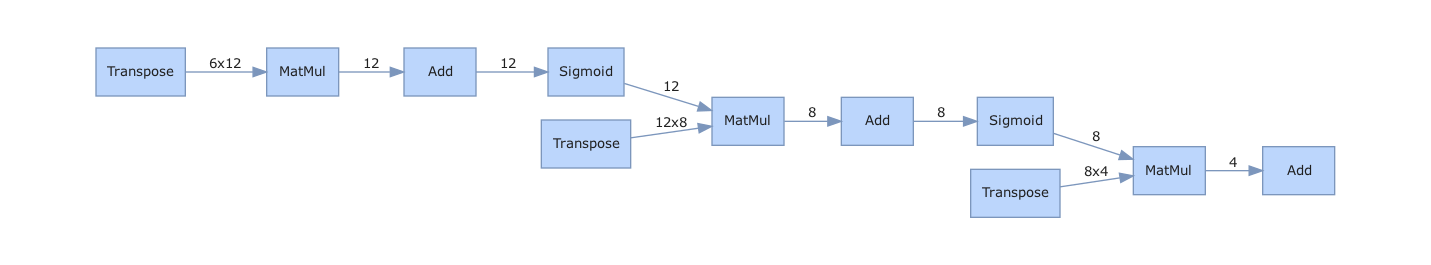

In [14]:
from IPython.display import Image
import hiddenlayer as h

model = MLPerceptron(6, [12,8], 4,'Sigmoid')

# plot the best network 
vis_graph = h.build_graph(model, torch.zeros([6]))
vis_graph.theme = h.graph.THEMES["blue"].copy()
# save the image to the image folder
vis_graph.save("image/network.png", format='png')


# to see the structure of the tree more clearly, open the png file in the image folder
Image(filename='image/network.png')


### 5. Model Training and Evaluation

In order to have the fixed results when training the network for times, we set a random state.

In [15]:
import random

# a function to set up the random state of PyTorch
def setup_random_state(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

# set the random state to ensure that the results of the model are fixed
setup_random_state(66)

Then, with the best combination of the hyper-parameters, we train a neural network on the training set.

In order to reuse the best model in the model ensemble part, we save the model to the "models" folder with torch.save() method.

In [16]:
# use the best combination of the hyper-parameters to train a network
model = MLPerceptron(6, [12,8], 4,'Sigmoid')
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200
best_validation_F1, training_loss_list, validation_loss_list, training_F1_list, validation_F1_list, best_model = train_model(model,epochs,optimizer,loss_func)
# save the model
torch.save(best_model,'models/Neural_Network.pth')

Epoch [1/200], Train Loss: 0.8259, Validation Loss: 0.7587
F1 Score (training set): 0.5775 F1 Score (validation set): 0.5757
Epoch [2/200], Train Loss: 0.6822, Validation Loss: 0.5963
F1 Score (training set): 0.6642 F1 Score (validation set): 0.6752
Epoch [3/200], Train Loss: 0.5377, Validation Loss: 0.4718
F1 Score (training set): 0.7926 F1 Score (validation set): 0.8191
Epoch [4/200], Train Loss: 0.4447, Validation Loss: 0.4024
F1 Score (training set): 0.8138 F1 Score (validation set): 0.8307
Epoch [5/200], Train Loss: 0.3725, Validation Loss: 0.3506
F1 Score (training set): 0.8545 F1 Score (validation set): 0.856
Epoch [6/200], Train Loss: 0.3314, Validation Loss: 0.2945
F1 Score (training set): 0.8601 F1 Score (validation set): 0.8542
Epoch [7/200], Train Loss: 0.3012, Validation Loss: 0.2917
F1 Score (training set): 0.8447 F1 Score (validation set): 0.8428
Epoch [8/200], Train Loss: 0.2756, Validation Loss: 0.2525
F1 Score (training set): 0.8576 F1 Score (validation set): 0.8494
E

/Users/guojingwei/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type MLPerceptron. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


To visualize the training process of the network, we plot the curves of the loss on the training set and on the validation set.

According to the figure, we can see that both of the two curves have levelled off after  200 epochs of training, which shows that the model has fitted well.

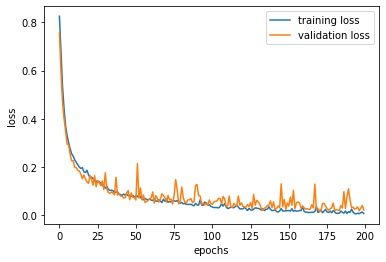

In [17]:
import matplotlib.pyplot as plt

# plot the curves of training loss and validation loss
plt.plot(training_loss_list, label="training loss")
plt.plot(validation_loss_list, label="validation loss")
# plot the legend
plt.legend(loc='upper right')

# set the x and y labels
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

Similarly, we also plot the weighted F1 score on the training set and on the validation set as the model trains.

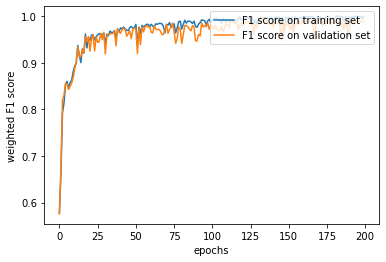

In [18]:
# plot the weighted F1 score on the training set and on the validation set
plt.plot(training_F1_list, label="F1 score on training set")
plt.plot(validation_F1_list, label="F1 score on validation set")
# plot the legend
plt.legend(loc='upper right')

# set the x and y labels
plt.ylabel('weighted F1 score')
plt.xlabel('epochs')
plt.show()

Finally, we check the prediction performance of the best model (i.e., the one which gets the highest weighted F1 score in the training process) on the test set.

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# a function used to predict on a dataset with a certain model 
def ouput_classification_report_and_confusion_matrix(xs,ys,model):
      xs = torch.from_numpy(xs).type(torch.FloatTensor)
      hat_ys = model(xs)
      _, hat_ys = torch.max(hat_ys, 1)
      ys_pred = hat_ys.numpy().tolist()
      class_report=classification_report(ys, ys_pred, digits=4)
      confusion_mat=confusion_matrix(ys,ys_pred)
      return class_report, confusion_mat

# print the classfication report
print('Classification Report of the Neural Network on the Test set: \n\n',
      ouput_classification_report_and_confusion_matrix(xs_test, ys_test, best_model)[0])


Classification Report of the Neural Network on the Test set: 

               precision    recall  f1-score   support

           0     0.9837    1.0000    0.9918       242
           1     0.9733    0.9481    0.9605        77
           2     1.0000    0.8462    0.9167        13
           3     0.9286    0.9286    0.9286        14

    accuracy                         0.9798       346
   macro avg     0.9714    0.9307    0.9494       346
weighted avg     0.9798    0.9798    0.9795       346



We also plot a confusion matrix with confusion_matrix() method in sklearn package and the heatmap() method in seaborn package to evaluate the classification performance of the model on each class.

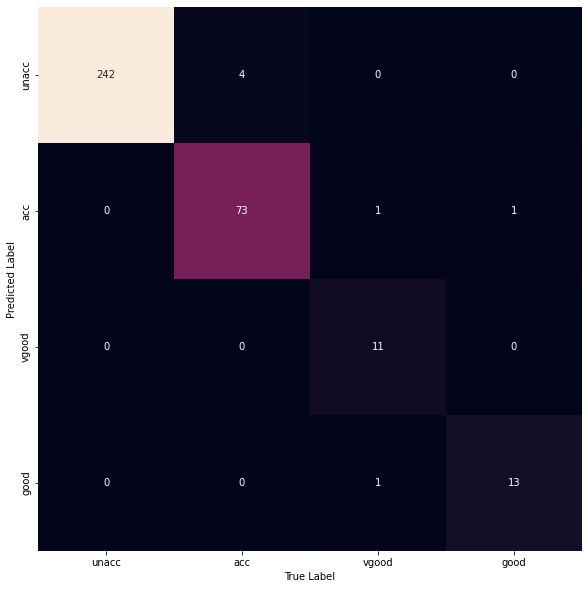

In [20]:
import seaborn as sns

# construct a confusion matrix which shows the accuracy on each class 
confusion_mat = ouput_classification_report_and_confusion_matrix(xs_test, ys_test, best_model)[1]

# plot the confusion matrix into a heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mat.T, square=True, annot=True, fmt='d',cbar=False,xticklabels=class_dic.values(),yticklabels=class_dic.values())
# set the x and y label of the figure
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()
